# プレトレーニングを目的としたオートエンコーダーの学習

Notebookで使用するTensorBoardをJupyter Notebook上で表示するための関数のソースを以下に示します<br>
ソース:https://github.com/ageron/handson-ml/blob/master/tensorflow_graph_in_jupyter.py

In [38]:
from __future__ import absolute_import, division, print_function, unicode_literals

# This module defines the show_graph() function to visualize a TensorFlow graph within Jupyter.

# As far as I can tell, this code was originally written by Alex Mordvintsev at:
# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb

# The original code only worked on Chrome (because of the use of <link rel="import"...>, but the version below
# uses Polyfill (copied from this StackOverflow answer: https://stackoverflow.com/a/41463991/38626)
# so that it can work on other browsers as well.

import numpy as np
import tensorflow as tf
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script src="//cdnjs.cloudflare.com/ajax/libs/polymer/0.3.3/platform.js"></script>
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

## データ準備

In [1]:
# kerasでMNISTデータをロード
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Using TensorFlow backend.


In [21]:
import numpy as  np

# MNISTデータを正規化
X_train = x_train.reshape(x_train.shape[0], -1) / 255.
X_test = x_test.reshape(x_test.shape[0], -1) / 255.

# モデルの入力にするために[サンプル数, 1]に配列の形状を変形
Y_train = y_train.reshape(-1, 1)
Y_test = y_test.reshape(-1, 1)

## オートエンコーダーモデルの構築

In [22]:
## ハイパーパラメーター ##
# ニューロン数
n_inputs = 28 * 28
n_hidden1 = 50
n_hidden2 = 20
n_hidden3 = n_hidden1
n_outputs = n_inputs

# 学習率
learning_rate = 0.001

In [23]:
## オートエンコーダーモデルの構築 ##
import tensorflow as tf

# グラフの初期化
tf.reset_default_graph()
X = tf.placeholder(dtype=tf.float32, shape=[None, n_inputs], name='X')
X_target = tf.placeholder(dtype=tf.float32, shape=[None, n_inputs], name='X_target')

# ニューラルネットワークの定義の構築 #
activation = tf.nn.elu
hidden1 = tf.layers.dense(X, n_hidden1, activation=activation, name='hidden1')
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=activation, name='hidden2')
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=activation, name='hidden3')
outputs_denoise = tf.layers.dense(hidden3, n_outputs, activation=None, name='outputs_denoise')

In [24]:
## 学習方法の設定 ##
# 損失関数: 再構築誤差
reconstruction_loss = tf.reduce_mean(tf.square(X_target - outputs_denoise), name='loss')

# オプティマイザ
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

# 保存
saver = tf.train.Saver()

In [39]:
# TensorBoardによる可視化
show_graph(tf.get_default_graph())

## オートエンコーダーモデルの学習

In [25]:
import datetime

#学習パラメータ
epoch_num=10
batch_size=100
# モデルの保存作
now = datetime.datetime.now().strftime("%Y-%m-%d-%H:%M")
ckpt_path = './models_for_exercise/{}/denoise_auto_encoder.ckpt'.format(now) # 学習済みモデルの保存ディレクトリ名は現在時刻を使用する

# MNISTデータからbatchを取得する関数
def fetch_batch(X, y, batch_size):
    num_data = X.shape[0]
    random_index = np.random.permutation(num_data)
    for batch_idx in np.array_split(random_index, batch_size):
        X_batch, y_batch = X[batch_idx, :], y[batch_idx]
        yield X_batch, y_batch

In [29]:
# 初期化変数の宣言
init = tf.global_variables_initializer()
with tf.Session() as sess:
    init.run()
    # エポックでループ
    for epoch in range(epoch_num):
        # バッチを取得し学習を行う
        for X_batch, y_batch in fetch_batch(X_train, y_train, batch_size):
            X_batch_noise = X_batch + np.random.normal(size=(X_batch.shape))# ノイズを混入
            sess.run(training_op, feed_dict={X:X_batch_noise, X_target:X_batch})
        #　最後のバッチにおける再構築誤差を計算 
        loss_val_last_batch = reconstruction_loss.eval(feed_dict={X:X_batch, X_target:X_batch})
        print("Epoch: {0} \tLast batch MSE: {1}".format(epoch, loss_val_last_batch))
    # テストデータにおける再構築誤差を計算
    X_test_noise = X_test + np.random.normal(size=(X_test.shape))# ノイズを混入
    loss_val_test = reconstruction_loss.eval(feed_dict={X:X_test_noise, X_target:X_test})
    print("===\tTest MSE: {0}===".format(loss_val_test))
    # モデルの保存
    tf.train.Saver().save(sess, ckpt_path)

Epoch: 0 	Last batch MSE: 0.05711618438363075
Epoch: 1 	Last batch MSE: 0.0470886304974556
Epoch: 2 	Last batch MSE: 0.040134407579898834
Epoch: 3 	Last batch MSE: 0.0365045927464962
Epoch: 4 	Last batch MSE: 0.032733481377363205
Epoch: 5 	Last batch MSE: 0.03418581560254097
Epoch: 6 	Last batch MSE: 0.03256369009613991
Epoch: 7 	Last batch MSE: 0.03150740638375282
Epoch: 8 	Last batch MSE: 0.03078094869852066
Epoch: 9 	Last batch MSE: 0.02976345084607601
===	Test MSE: 0.03738117963075638===


## ノイズ除去機能の確認

In [31]:
# サンプルデータから出力を生成
num_sample = 100
num_X_train = X_train.shape[0]

# サンプルの生成
rnd_idx = np.random.permutation(num_X_train)[:num_sample]
sample = X_train[rnd_idx]
noise = np.random.normal(size=(sample.shape))
sample_with_noise = sample + noise
ckpt_path_sample = ckpt_path

with tf.Session() as sess:
    saver.restore(sess, ckpt_path_sample)
    sample_denoised = outputs_denoise.eval(feed_dict={X:sample})
    sample_denoised_noise_input = outputs_denoise.eval(feed_dict={X:sample_with_noise})

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./models_for_exercise/2020-02-12-07:54/denoise_auto_encoder.ckpt


In [34]:
import matplotlib.pyplot as plt

# 100個のMNIST画像を表示する
def plot_image(image, num_sample):
    """Plot the array of image in 10 by 10 matrix
    Args:
        image (numpy.array): Image in array to be shown. shape must be (num_sample, 784)
        num_sample (int)   : total number of samples
    Returns:
        None
    Note:
        Show image of the given array in 10 by 10 matrix
    """
    plt.figure(figsize=(16, 80))
    image_reshaped = image.reshape(-1,28,28)
    for idx in range(num_sample):
        plt.subplot(num_sample, 10, idx + 1)
        plt.imshow(image_reshaped[idx], cmap='gray')
        plt.axis('off')

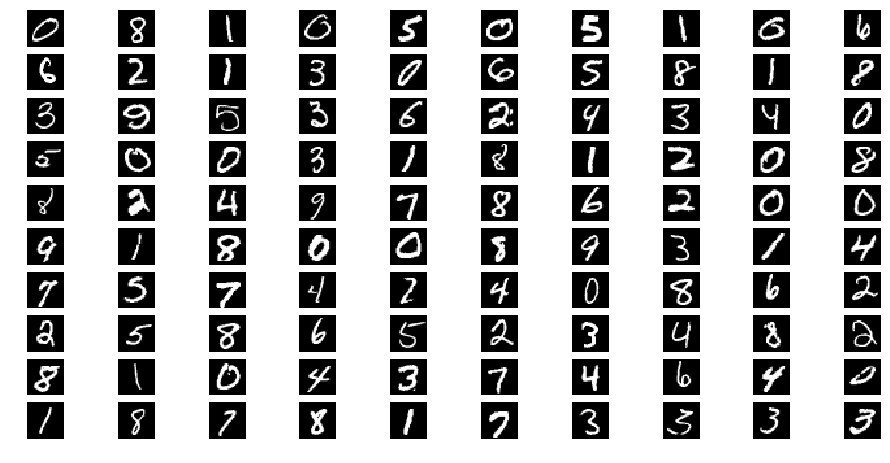

In [35]:
# 元データの出力
plot_image(sample, num_sample)

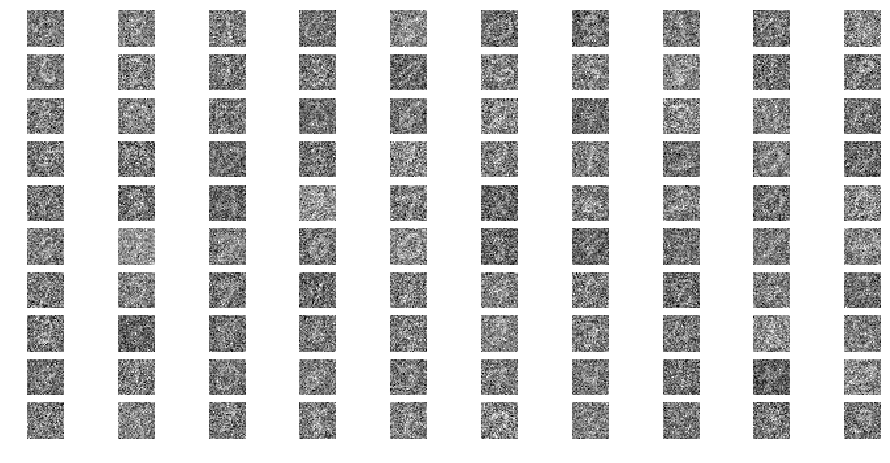

In [36]:
# 元データ＋ノイズ
plot_image(sample_with_noise, num_sample)

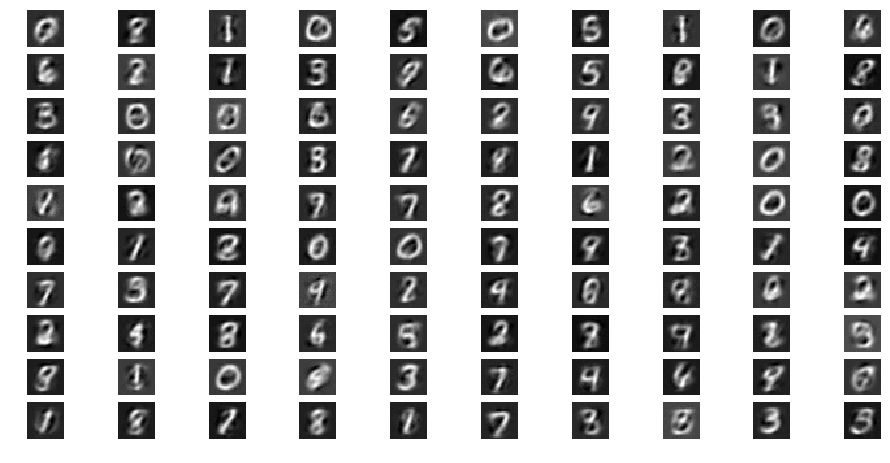

In [37]:
# ノイズデータに対する出力
plot_image(sample_denoised_noise_input, num_sample)

# プレトレーニングを用いたMNIST画像識別器の学習

## オートエンコーダーモデルを再利用したMNIST画像識別モデルの構築

保存したオートエンコーダーモデルを再利用するために、TensorFlowグラフ内の変数名を取得します。モデルが正常に保存できていれば、そのディレクトリに'ファイル名.meta'というファイルが存在するはずです。これを読み出すことで欲しい層の変数を取得します。<br>
出力を見るとモデル構築で指定したname属性の値である'X', 'hidden1', 'hidden2'が正しく反映されているが分かります。今回は隠れ層1と2の活性化関数の出力まで利用します。(自分で作ったモデルなら変数名を調べるまでもないですが、ネットで拾った時には確認が必要かと思います。)

In [40]:
# グラフメタファイルのパス
ckpt_meta = ckpt_path + '.meta'

# グラフをリセット
tf.reset_default_graph()
saver_new = tf.train.import_meta_graph(ckpt_meta)

# メタ情報の表示
for op in tf.get_default_graph().get_operations():
    print(op.name)

X
X_target
hidden1/kernel/Initializer/random_uniform/shape
hidden1/kernel/Initializer/random_uniform/min
hidden1/kernel/Initializer/random_uniform/max
hidden1/kernel/Initializer/random_uniform/RandomUniform
hidden1/kernel/Initializer/random_uniform/sub
hidden1/kernel/Initializer/random_uniform/mul
hidden1/kernel/Initializer/random_uniform
hidden1/kernel
hidden1/kernel/Assign
hidden1/kernel/read
hidden1/bias/Initializer/zeros
hidden1/bias
hidden1/bias/Assign
hidden1/bias/read
hidden1/MatMul
hidden1/BiasAdd
hidden1/Elu
hidden2/kernel/Initializer/random_uniform/shape
hidden2/kernel/Initializer/random_uniform/min
hidden2/kernel/Initializer/random_uniform/max
hidden2/kernel/Initializer/random_uniform/RandomUniform
hidden2/kernel/Initializer/random_uniform/sub
hidden2/kernel/Initializer/random_uniform/mul
hidden2/kernel/Initializer/random_uniform
hidden2/kernel
hidden2/kernel/Assign
hidden2/kernel/read
hidden2/bias/Initializer/zeros
hidden2/bias
hidden2/bias/Assign
hidden2/bias/read
hidden2/

再利用する層の名前が判明したのでMNIST画像を識別するモデルを構築します。

In [41]:
## ハイパーパラメータ
# Graphのリセット
tf.reset_default_graph()

n_outputs = 10 # 出力層の数
learning_rate = 0.001 # 学習率

## モデル構築
# モデル再利用のためのSaver
resotre_saver = tf.train.import_meta_graph(ckpt_meta)
# 入力の定義 (Xは再利用する)
X = tf.get_default_graph().get_tensor_by_name("X:0") ### <- 変数の再利用!!!
y = tf.placeholder(dtype=tf.int32, shape=[None])

# hidden2までを再利用
hidden1 = tf.get_default_graph().get_tensor_by_name("hidden1/Elu:0")### <- 変数の再利用!!!
hidden2 = tf.get_default_graph().get_tensor_by_name("hidden2/Elu:0")### <- 変数の再利用!!!
# 出力を新規に追加
logits = tf.layers.dense(hidden2, n_outputs, activation=None, name='logits')

## 学習の設定
# 損出関数
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name='loss')

# オプティマイザ
with tf.name_scope("train"):
    new_optimizer = tf.train.AdamOptimizer(learning_rate, name='Adam_clf')
    training_op_clf = new_optimizer.minimize(loss)

# 精度評価
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy')

構築したオートエンコーダーを再利用したMNIST画像識別モデルのネットワーク構成は以下に示します。オートエンコーダーの隠れ層の出力の先にMNIST画像識別用のそうが付加されていることがわかります。

In [42]:
# TensorBoardによる可視化
show_graph(tf.get_default_graph())

## プレトレーニングを用いたMNIST画像識別モデルの学習

学習データサイズを100-60000で変化させ、MNIST画像識別器を10epochで学習させます。各学習データサイズでの学習終了後にテストデータ(データ数10000)を用いて正解率を算出し配列に格納します。

In [43]:
def trainClf(X_train, y_train, X_test, y_test, 
             training_op, restore_ckpt_path=None, ckpt_save_path=None, 
             epoch=10, batch_size=100, save=False):
    """Function to train classifier
    Args:
        X_train (numpy.array): Input to train model
        y_train (numpy.array): Label to train model
        X_test (numpy.array):  Input to calculate MSE for testing
        y_test (numpy.array):  Label to calculate MSE for testing
        training_op (tensorflow function): Training operator
        restore_ckpt_path (String): Path to resotre model
        ckpt_save_path (String):    Path to save the trained model
        epoch (int):           Number of epoch
        batch_size (int):      Size of the batch
        save (boolean): Flag to save the model
    Returns:
        acc_val_test (float): accuracy value for the test set
    Note:
        Trained model will be saved after complete trainig
    """
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        init.run()
        # モデルの呼び出し
        if restore_ckpt_path is not None:
            print("Restore model!")
            resotre_saver.restore(sess, restore_ckpt_path)
        
        # 学習の実行 (Epoch)
        for iter in range(epoch):
            # 学習の実行 (Batch)
            for X_batch, y_batch in fetch_batch(X_train, y_train, batch_size):
                sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
            acc_val_train = accuracy.eval(feed_dict={X:X_batch ,y:y_batch})
            print("Epoch:{0}   train_acc:{1}".format(iter, acc_val_train))
        acc_val_test = accuracy.eval(feed_dict={X:X_test ,y:y_test})
        print("=== Final_accuracy: {}===".format(acc_val_test))
        
        # モデルの保存
        if save:
            if ckpt_save_path is None:
                print("Failed to save")
                print("Please define file path to save model")
            else:
                saver_new = tf.train.Saver()
                saver_new.save(sess, ckpt_save_path)
    return acc_val_test

In [44]:
## テストデータの大きさに対する精度を格納する
# 検証用データのインデックス
data_size_array = [100, 300, 500, 1000, 2500, 5000, 10000, 30000, 60000]

# 結果格納用配列
acc_list = []

for data_size in data_size_array:
    print("Data size: {}".format(data_size))
    X_train_extracted, y_train_extracted = X_train[:data_size], y_train[:data_size]
    # 学習を実行しテストデータの精度を返す
    acc_val_test = trainClf(X_train_extracted, y_train_extracted,
                            X_test, y_test, training_op_clf, 
                            restore_ckpt_path=ckpt_path, epoch=10)
    acc_list.append(acc_val_test)

Data size: 100
Restore model!
INFO:tensorflow:Restoring parameters from ./models_for_exercise/2020-02-12-07:54/denoise_auto_encoder.ckpt
Epoch:0   train_acc:0.0
Epoch:1   train_acc:1.0
Epoch:2   train_acc:1.0
Epoch:3   train_acc:1.0
Epoch:4   train_acc:1.0
Epoch:5   train_acc:1.0
Epoch:6   train_acc:1.0
Epoch:7   train_acc:1.0
Epoch:8   train_acc:1.0
Epoch:9   train_acc:1.0
=== Final_accuracy: 0.6880999803543091===
Data size: 300
Restore model!
INFO:tensorflow:Restoring parameters from ./models_for_exercise/2020-02-12-07:54/denoise_auto_encoder.ckpt
Epoch:0   train_acc:0.0
Epoch:1   train_acc:0.3333333432674408
Epoch:2   train_acc:0.6666666865348816
Epoch:3   train_acc:1.0
Epoch:4   train_acc:1.0
Epoch:5   train_acc:1.0
Epoch:6   train_acc:1.0
Epoch:7   train_acc:1.0
Epoch:8   train_acc:0.6666666865348816
Epoch:9   train_acc:1.0
=== Final_accuracy: 0.7813000082969666===
Data size: 500
Restore model!
INFO:tensorflow:Restoring parameters from ./models_for_exercise/2020-02-12-07:54/denois

Text(0, 0.5, 'Test Accuracy')

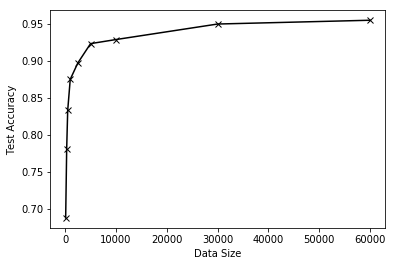

In [45]:
# データサイズに対する精度の推移
plt.plot(data_size_array, acc_list, marker='x', color='black')
plt.xlabel("Data Size")
plt.ylabel("Test Accuracy")

# プレトレーニングの効果検証

## プレトレーニングを用いないMNIST画像識別モデルの構築と学習 

プレトレーニングを行わない通常のMNIST画像識別器を生成します。モデルの構成は今までと同じです。

In [46]:
tf.reset_default_graph()
## ハイパーパラメータ
n_inputs = 28 * 28
n_hidden1 = 50
n_hidden2 = 20
n_outputs = 10
learning_rate = 0.001

## モデル構築
# 入力
X = tf.placeholder(tf.float32, shape=[None, n_inputs])
y = tf.placeholder(tf.int32, shape=[None])
# ネットワークの構築
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.elu, name='hidden1_no_pretrain')
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.elu, name='hidden2_no_pretrain')
logits = tf.layers.dense(hidden2, n_outputs, activation=None, name='logits_no_pretrain')

## 学習の設定
# 損失関数
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
loss = tf.reduce_mean(xentropy, name='loss_no_pretrain')
# オプティマイザ
optimizer = tf.train.AdadeltaOptimizer(learning_rate, name='Adam_no_pretrain')
training_op_no_pretrain = optimizer.minimize(loss)
# 精度評価
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy')
# 初期化と保存
saver_no_pretrain = tf.train.Saver()

## プレトレーニングの効果を評価

プレトレーニングありの場合と同様に、学習データサイズを100-60000で変化させてMNIST画像識別器を10epochで学習させます。

In [47]:
## テストデータの大きさに対する精度を格納する
# 検証用データのインデックス
data_size_array = [100, 300, 500, 1000, 2500, 5000, 10000, 30000, 60000]

# 結果格納用配列
acc_list_no_pretrain = []

for data_size in data_size_array:
    print("Data size: {}".format(data_size))
    X_train_extracted, y_train_extracted = X_train[:data_size], y_train[:data_size]
    acc_val_test = trainClf(X_train_extracted, y_train_extracted,
                            X_test, y_test, training_op_no_pretrain, epoch=10)
    acc_list_no_pretrain.append(acc_val_test)

Data size: 100
Epoch:0   train_acc:1.0
Epoch:1   train_acc:0.0
Epoch:2   train_acc:0.0
Epoch:3   train_acc:0.0
Epoch:4   train_acc:0.0
Epoch:5   train_acc:0.0
Epoch:6   train_acc:0.0
Epoch:7   train_acc:0.0
Epoch:8   train_acc:0.0
Epoch:9   train_acc:0.0
=== Final_accuracy: 0.11630000174045563===
Data size: 300
Epoch:0   train_acc:0.0
Epoch:1   train_acc:0.0
Epoch:2   train_acc:0.0
Epoch:3   train_acc:0.0
Epoch:4   train_acc:0.0
Epoch:5   train_acc:0.0
Epoch:6   train_acc:0.0
Epoch:7   train_acc:0.6666666865348816
Epoch:8   train_acc:0.0
Epoch:9   train_acc:0.0
=== Final_accuracy: 0.08560000360012054===
Data size: 500
Epoch:0   train_acc:0.20000000298023224
Epoch:1   train_acc:0.0
Epoch:2   train_acc:0.0
Epoch:3   train_acc:0.20000000298023224
Epoch:4   train_acc:0.6000000238418579
Epoch:5   train_acc:0.4000000059604645
Epoch:6   train_acc:0.0
Epoch:7   train_acc:0.20000000298023224
Epoch:8   train_acc:0.0
Epoch:9   train_acc:0.20000000298023224
=== Final_accuracy: 0.1834000051021576==

以下にプレトレーニング有無による正解率の違いを示します。黒線がプレトレーニングあ、青線がプレトレーニングなしの結果です。プレトレーニングなしの場合は60000全てのデータを用いても、10epochでは正解率が13%程度しか得られないということがわかりました。ノイズ除去オートエンコーダーによるプレトレーニングはとても効果がありそうです！！！

(0, 1.0)

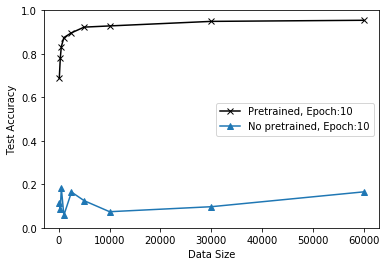

In [48]:
# データサイズに対する精度の推移
plt.plot(data_size_array, acc_list, marker='x', color='black', label='Pretrained, Epoch:10')
plt.plot(data_size_array, acc_list_no_pretrain, marker='^', label='No pretrained, Epoch:10')
plt.legend()
plt.xlabel("Data Size")
plt.ylabel("Test Accuracy")
plt.ylim(0,1.0)